# Exploratory notebook for miniblock decoding analysis
#### Plot decoding as a function of miniblock

In [330]:
import numpy as np
import scipy.stats as stats
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import pandas as pd
import loadTaskBehavioralData as task
import tools
import multiprocessing as mp
import statsmodels.stats.multitest as mc
%matplotlib inline

#### Parameter set up

In [331]:
projectdir = '/projects3/CPROCompositionality/'
datadir = projectdir + 'data/processedData/' 
resultdir = projectdir + 'data/results/'
subjNums = ['013','014','016','017','018','021','023','024','026','027','028',
            '030','031','032','033','034','035','037','038','039','040','041',
            '042','043','045','046','047','048','049','050','053','055','056',
            '057','058','062','063','066','067','068','069','070','072','074',
            '075','076','077','081','085','086','087','088','090','092','093',
            '094','095','097','098','099','101','102','103','104','105','106',
            '108','109','110','111','112','114','115','117','119','120','121',
            '122','123','124','125','126','127','128','129','130','131','132',
            '134','135','136','137','138','139','140','141']

glasser = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = nib.load(glasser).get_data()
glasser = np.squeeze(glasser)
rois = np.arange(1,361)

#### Load in CAB-NP ROI labels
cabn_labels = pd.read_csv(projectdir + 'data/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt',header=0,delimiter='\t')
df_labels = cabn_labels.iloc[0:360]
df_labels.reset_index()
del df_labels['INDEX'], df_labels["KEYVALUE"]

# Using final partition
networkdef = df_labels['NETWORKKEY'].values
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}

In [187]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Identify which regions are sensitive to negations 

In [338]:
df_negation = pd.read_csv(resultdir + 'CrossSubjectLogicalNegationDecoding/CrossSubjectLogicalNegationDecoding_allROIs.csv')
chance = 0.5
rois = np.unique(df_negation.ROI)
accuracy = []
ps = []
for roi in np.sort(rois):
    tmp_df = df_negation.loc[df_negation.ROI==roi]
    acc = tmp_df.DecodingAccuracy.values
    p = stats.binom_test(np.mean(acc),n=len(acc),p=chance)
    p = p/2.0 if np.mean(acc)>chance else 1.0-p/2.0
    ps.append(p)
    accuracy.append(np.mean(acc))

qs = mc.fdrcorrection(ps)[0]
accuracy = np.asarray(accuracy)
sig_acc = np.multiply(accuracy,qs)
data = np.zeros((len(accuracy),2))
data[:,0] = accuracy
data[:,1] = sig_acc
tools.mapBackToSurface(data,resultdir + 'LogicalNegationDecodingWholeBlock')

#### Logic rule decoding

In [351]:
chance = 1/4.0
accuracy = []
ps = []
df_plot = {}
df_plot['ROI'] = []
df_plot['Rule'] = []
df_plot['Accuracy'] = []
df_plot['Block'] = []
roi_ind = np.where(networkdef==networkmappings['vis2'])[0]
roi_ind = [110]
for roi in roi_ind:
    df_logic = pd.read_csv(resultdir + 'CrossSubjectLogicRuleDecoding/CrossSubjectLogicRuleDecoding_roi' + str(roi+1) + '.csv')
    rules = np.unique(df_logic.LogicRules.values)
    for rule in rules:
        tmpdf = df_logic.loc[df_logic.LogicRules==rule]
        subj_mb_data = []
        for subj in np.unique(tmpdf.Subject.values):
            tmpdf2 = tmpdf.loc[tmpdf.Subject==subj]
            subj_mb_data.append(tmpdf2.DecodingAccuracy.values)
        subj_mb_data = np.asarray(subj_mb_data) # subject x miniblock (per rule) data
        
        mbcount = 1
        for mb in range(subj_mb_data.shape[1]):
            df_plot['Block'].append(mbcount)
            df_plot['Accuracy'].append(np.mean(subj_mb_data[:,mb]))
            df_plot['Rule'].append(rule)
            df_plot['ROI'].append(roi)
            mbcount += 1
#     subjs = np.unique(df_logic.Subject.values)
#     subjaccuracy = []
#     for subj in subjs:
#         tmpdf = df_logic.loc[df_logic.Subject==subj]
#         acc = np.mean(tmpdf.DecodingAccuracy.values)
#         subjaccuracy.append(acc)
    
#     t, p = stats.ttest_1samp(subjaccuracy,chance)
#     p = p/2.0 if np.mean(subjaccuracy)>chance else 1.0-p/2.0
#     ps.append(p)
#     accuracy.append(np.mean(subjaccuracy))

# logic_regions = np.where(mc.fdrcorrection(ps)[0])[0]

#### intersection
# regions_interest = np.multiply(logic_regions,novelty_regions)
# fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
# con_ind = np.where(networkdef==networkmappings['con'])[0]
# net_ind = np.hstack((fpn_ind,con_ind))
# regions_interest = np.intersect1d(fpn_ind,logic_regions)

df_plot = pd.DataFrame(df_plot)

In [360]:
df_logic.TaskPerformance

0            Correct
1            Correct
2         Wrong Hand
3            Correct
4        No Response
5            Correct
6            Correct
7            Correct
8              Wrong
9            Correct
10             Wrong
11             Wrong
12           Correct
13             Wrong
14           Correct
15           Correct
16           Correct
17           Correct
18           Correct
19           Correct
20           Correct
21             Wrong
22           Correct
23           Correct
24           Correct
25           Correct
26             Wrong
27           Correct
28           Correct
29           Correct
            ...     
12258        Correct
12259          Wrong
12260        Correct
12261        Correct
12262        Correct
12263        Correct
12264        Correct
12265        Correct
12266        Correct
12267          Wrong
12268        Correct
12269        Correct
12270        Correct
12271        Correct
12272        Correct
12273        Correct
12274        

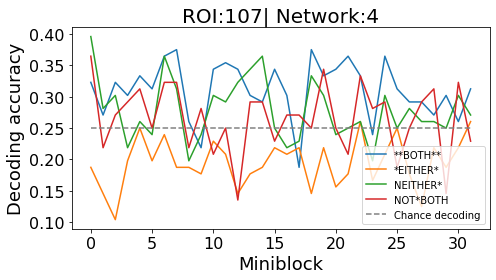

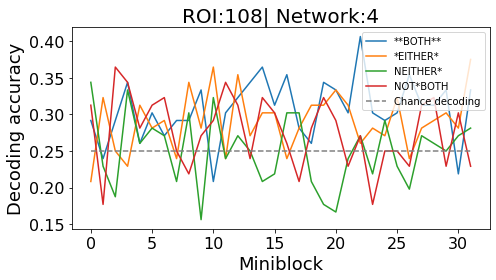

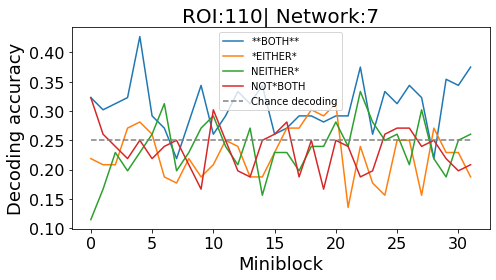

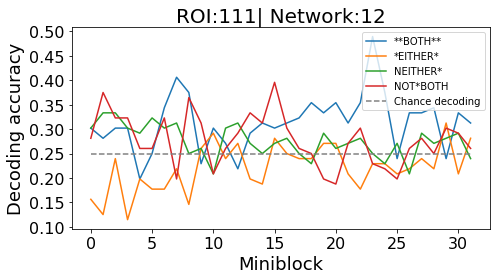

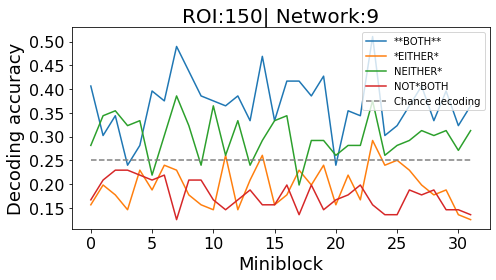

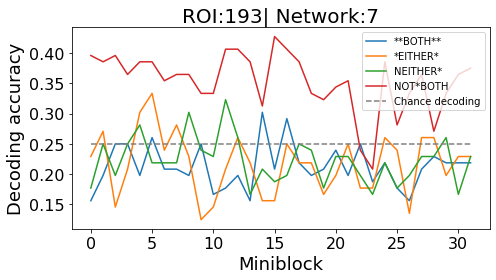

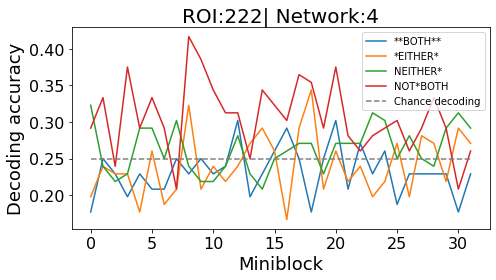

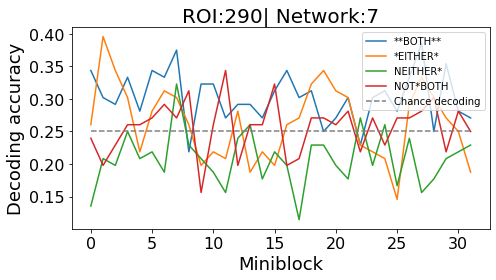

In [358]:
regions_interest = np.where(data[:,0]>0.62)[0]
for roi in regions_interest:
    plt.figure(figsize=(7,4))
    for rule in rule_accuracy[roi]:
        #plt.plot(moving_average(rule_accuracy[roi][rule],n=10),label=rule)
        plt.plot(rule_accuracy[roi][rule],label=rule)
    plt.plot(np.arange(len(rule_accuracy[roi][rule])),np.repeat(chance,len(rule_accuracy[roi][rule])),'gray',linestyle='--',label='Chance decoding')
    plt.title('ROI:' + str(roi)+ '| Network:' + str(networkdef[roi]),fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Miniblock',fontsize=18)
    plt.ylabel('Decoding accuracy',fontsize=18)
    plt.legend()
    plt.tight_layout()